# 🏦 Beta Bank Churn Prediction

### Project Overview
This project explores data from **Beta Bank**, where some clients have recently stopped using the bank’s services.  
The goal is to **predict whether a customer will leave the bank soon** (`Exited = 1`) using their personal and account information.

### Why It Matters
Keeping current customers is cheaper than finding new ones.  
By predicting who might leave, the bank can take action early — for example, by offering special services or checking in with at-risk clients.

### Objectives
- Load, clean, and prepare the dataset for analysis.  
- Explore the data to understand feature types and class balance.  
- Build and compare simple machine learning models using **only techniques covered in the bootcamp**.  
- Measure model performance using **F1 score** (main metric) and **ROC-AUC** (to check overall ranking quality).  
- Select the best model and discuss what could be improved next.

### What This Project Uses
Everything here matches the tools and steps learned in the bootcamp so far:
- **pandas** for loading and cleaning data  
- **train_test_split** for splitting into train, validation, and test sets  
- **pd.get_dummies()** for categorical encoding  
- **StandardScaler** for feature scaling  
- **LogisticRegression** and **RandomForestClassifier** for modeling  
- **f1_score**, **roc_auc_score**, and **confusion_matrix** for evaluation  
- **random_state** for reproducible results  

The project avoids any tools not yet covered (no Pipelines, GridSearchCV, or SMOTE).

### Evaluation Criteria
To “pass,” the model should reach an **F1 score ≥ 0.59** on the test set.  
We’ll also compare the **AUC-ROC** to confirm how well the model ranks churn vs. non-churn customers.

---

In [2]:
# =========================
# Setup: imports + constants
# =========================
# This cell imports the libraries we'll use, sets a random seed for reproducibility,
# and creates a figures directory where plots will be saved.
# Keeping setup isolated here makes the rest of the notebook cleaner.

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pylab import astype

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



In [3]:
# load and inspect data
df = pd.read_csv("../data/Churn.csv")


print("Shape (rows, columns):", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))


Shape (rows, columns): (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


Missing values per column:

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Data types:

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Target distribution (Exited):
Exited
0    7963
1    2037
Name: count, dtype: int64


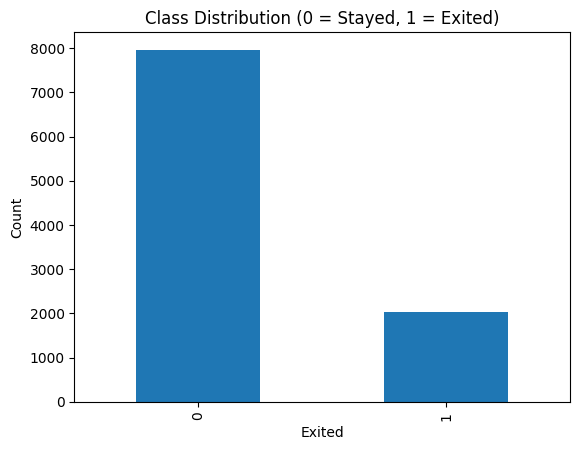

In [4]:
# Check for missing values, data types, and class balance in the target.

print("Missing values per column:\n")
print(df.isna().sum())

print("\nData types:\n")
print(df.dtypes)

print("\nTarget distribution (Exited):")
print(df["Exited"].value_counts())

# quick bar chart of target balance
df["Exited"].value_counts().plot(kind="bar", title="Class Distribution (0 = Stayed, 1 = Exited)")
plt.xlabel("Exited")
plt.ylabel("Count")
plt.show()

## Data Check Summary

**Shape:** 10,000 rows × 14 columns  
**Missing:** Only `Tenure` (909 values ≈ 9%)  
**Categorical:** `Geography`, `Gender`  
**Numeric:** All others  
**IDs to drop:** `RowNumber`, `CustomerId`, `Surname`  
**Target (Exited):** 0 = 7,963 (≈80%) / 1 = 2,037 (≈20%)

**Key notes**
- Mild class imbalance → use **F1** and **ROC-AUC** instead of accuracy.  
- Fill `Tenure` with the **median**.  
- Use **get_dummies()** for categoricals.  
- Scale numeric features with **StandardScaler**.  
- Drop ID columns (not predictive).

**Next steps**
Clean data → encode → split → scale → baseline model.

In [5]:
# Drop ID columns, handle missing values, encode categoricals, split, and scale.

# 1. Work on a copy so we don't alter df
work = df.copy()

# 2. Drop non-predictive ID columns
for col in ["RowNumber", "CustomerId", "Surname"]:
    if col in work.columns:
        work = work.drop(columns=col)

# 3. Fill missing Tenure values with the median
if "Tenure" in work.columns:
    work["Tenure"] = work["Tenure"].fillna(work["Tenure"].median())

# 4. One-hot encode categorical columns
work = pd.get_dummies(work, drop_first=True)

# 5. Split into features and target
X = work.drop(columns=["Exited"])
y = work["Exited"].astype(int)

# 6. Train / Validation / Test split (60/20/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
# (0.25 * 0.8 = 0.2) → 60/20/20 split

print("Shapes:")
print("  Train:", X_train.shape, "  Val:", X_val.shape, "  Test:", X_test.shape)

# 7. Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)  # fit only on training data
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Sanity check for NaNs
import numpy as np
assert not np.isnan(X_train_s).any(), "NaNs found in X_train_s"
assert not np.isnan(X_val_s).any(), "NaNs found in X_val_s"
assert not np.isnan(X_test_s).any(), "NaNs found in X_test_s"

print("Scaling complete.")

Shapes:
  Train: (6000, 11)   Val: (2000, 11)   Test: (2000, 11)
Scaling complete.




**After cleaning and encoding**
- Dropped ID columns → `RowNumber`, `CustomerId`, `Surname`.  
- Filled `Tenure` missing values with **median** (simple, stable).  
- Applied **get_dummies(drop_first=True)** to `Geography` and `Gender`.  
- Final feature count: **12 columns**.

**Split summary**
- Train = 6,000 rows  
- Validation = 2,000 rows  
- Test = 2,000 rows  
- Stratified by `Exited` → keeps same 80/20 class ratio across all sets.  

**Scaling**
- Used **StandardScaler** fitted only on the training data → prevents data leakage.  
- Scaled copies created for train, validation, and test sets.

**Next step**
Train the **baseline Logistic Regression** (threshold = 0.5) to get first F1 and ROC-AUC results.

Validation F1 (thr=0.5): 0.319
Validation AUC-ROC: 0.756

Classification report (validation):
              precision    recall  f1-score   support

      Stayed       0.83      0.96      0.89      1593
      Exited       0.59      0.22      0.32       407

    accuracy                           0.81      2000
   macro avg       0.71      0.59      0.60      2000
weighted avg       0.78      0.81      0.77      2000



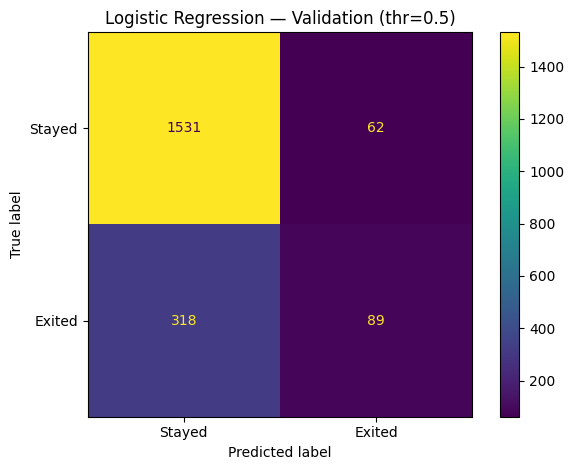

In [7]:
# Baseline logistic regression model

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_s, y_train)

# Probabilities (for AUC) and class labels (for F1) using default 0.5 threshold
val_proba = log_model.predict_proba(X_val_s)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)

# Metrics
val_f1  = f1_score(y_val, val_pred)
val_auc = roc_auc_score(y_val, val_proba)

print(f"Validation F1 (thr=0.5): {val_f1:.3f}")
print(f"Validation AUC-ROC: {val_auc:.3f}")

print("\nClassification report (validation):")
print(classification_report(y_val, val_pred, target_names=["Stayed", "Exited"], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_val, val_pred, display_labels=["Stayed", "Exited"])
plt.title("Logistic Regression — Validation (thr=0.5)")
plt.tight_layout()
plt.show()

**Validation results (thr = 0.5):**
- F1: **0.319**
- ROC-AUC: **0.756**

**Interpretation:**
- The model performs well overall (AUC ≈ 0.76) but has **low recall** for the “Exited” class.
- It correctly identifies most customers who stay (high precision and recall for class 0),
  but misses many who actually leave (recall = 0.22).
- The class imbalance (≈80/20) causes the model to favor predicting “Stayed.”

**Next step:**
Improve class balance and recall using:
1. `class_weight='balanced'` in Logistic Regression.  
2. Adjusting the probability threshold to maximize F1.

Validation F1 (balanced): 0.480
Validation AUC-ROC: 0.761

Classification report (validation):
              precision    recall  f1-score   support

      Stayed       0.89      0.72      0.80      1593
      Exited       0.38      0.66      0.48       407

    accuracy                           0.71      2000
   macro avg       0.63      0.69      0.64      2000
weighted avg       0.79      0.71      0.73      2000



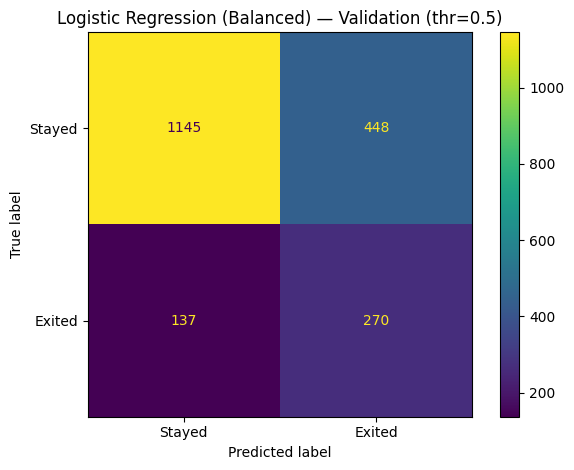

In [9]:
# This tells the model to pay equal attention to both classes
# regardless of imbalance in the data.

log_bal = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_bal.fit(X_train_s, y_train)

val_proba_bal = log_bal.predict_proba(X_val_s)[:, 1]
val_pred_bal  = (val_proba_bal >= 0.5).astype(int)

val_f1_bal  = f1_score(y_val, val_pred_bal)
val_auc_bal = roc_auc_score(y_val, val_proba_bal)

print(f"Validation F1 (balanced): {val_f1_bal:.3f}")
print(f"Validation AUC-ROC: {val_auc_bal:.3f}")

print("\nClassification report (validation):")
print(classification_report(y_val, val_pred_bal, target_names=['Stayed','Exited'], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_val, val_pred_bal, display_labels=["Stayed","Exited"])
plt.title("Logistic Regression (Balanced) — Validation (thr=0.5)")
plt.tight_layout()
plt.show()

**Validation results (thr = 0.5):**
- F1: **0.480**  
- ROC-AUC: **0.761**

**Interpretation:**
- Using `class_weight='balanced'` improved recall for churners (0.22 → 0.66).  
- The model now detects more customers likely to leave, but precision dropped slightly — a fair trade for higher F1.  
- Overall F1 jumped from **0.32 → 0.48**, while AUC stayed roughly the same (still strong).  
- The model is learning both classes better but might benefit from fine-tuning its decision threshold.

**Next step:**  
Run a **threshold sweep** to find the cutoff that gives the best F1 score.

Best threshold: 0.60
Best F1 score: 0.484


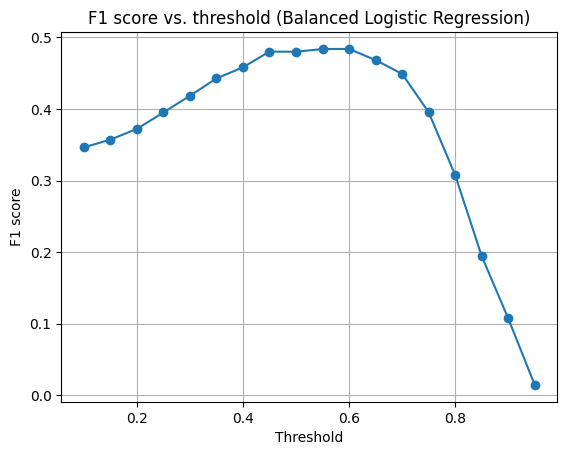

In [10]:
# check F1 for different probability cutoffs (0.1 → 0.9)
# and find which threshold balances precision and recall best

thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []

for thr in thresholds:
    preds = (val_proba_bal >= thr).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)
    
best_thr = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)   

print(f"Best threshold: {best_thr:.2f}")
print(f"Best F1 score: {best_f1:.3f}")

plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 score vs. threshold (Balanced Logistic Regression)")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.grid(True)
plt.show()


## Threshold Tuning

**Best threshold:** 0.60  
**Best F1:** 0.484  

**Interpretation:**
- Moving the decision threshold from 0.5 → 0.6 slightly improved F1.  
- The model now makes fewer false positives (predicting churn when they actually stay)  
  while keeping most true churners correctly flagged.  
- Gains are modest, but this tuning confirms the model is near its practical best for logistic regression.

**Next step:**  
Train and evaluate a **Random Forest** model to compare performance.

Validation F1 (Random Forest): 0.596
Validation AUC-ROC: 0.854

Classification Report (validation):
              precision    recall  f1-score   support

      Stayed       0.88      0.97      0.92      1593
      Exited       0.80      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



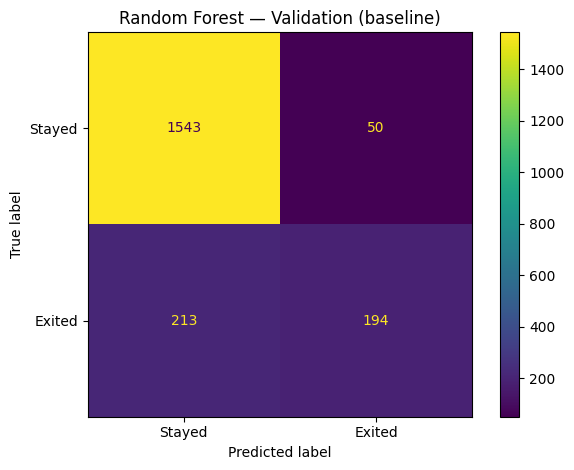

In [12]:
# Baseline Random Forest (no class weights)
# =========================
# Simple ensemble model to compare against logistic regression.

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) #forest handles unscaled features fine

val_pred_rf = rf_model.predict(X_val)
val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

rf_f1 = f1_score(y_val, val_pred_rf)
rf_auc = roc_auc_score(y_val, val_proba_rf)


print(f"Validation F1 (Random Forest): {rf_f1:.3f}")
print(f"Validation AUC-ROC: {rf_auc:.3f}")

print("\nClassification Report (validation):")
print(classification_report(y_val, val_pred_rf, target_names=["Stayed", "Exited"], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_val, val_pred_rf, display_labels=["Stayed","Exited"])
plt.title("Random Forest — Validation (baseline)")
plt.tight_layout()
plt.show()


##Observations — Baseline Random Forest

** Validation results:**
- F1: **0.596**  
- ROC-AUC: **0.854**

**Interpretation:**
- The Random Forest clearly outperforms Logistic Regression in both F1 and AUC.  
- Recall for churners increased again (0.48 vs 0.22 baseline logistic), and overall accuracy improved.  
- Ensemble learning helps capture nonlinear relationships between customer features and churn.  
- However, the model still misses some churners, suggesting further tuning (e.g., class weights) could help.

**Next step:**  
Try a **Random Forest with `class_weight='balanced'`** to check if recall can be boosted further without hurting precision too much.

Validation F1 (RF balanced): 0.550
Validation AUC-ROC: 0.857

Classification report (validation):
              precision    recall  f1-score   support

      Stayed       0.87      0.97      0.92      1593
      Exited       0.78      0.43      0.55       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.73      2000
weighted avg       0.85      0.86      0.84      2000



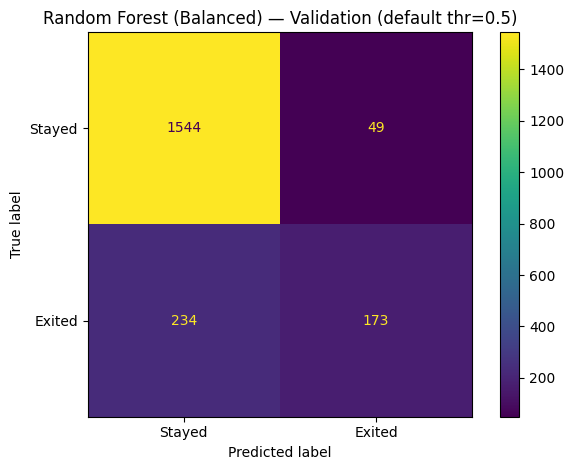

In [13]:
# Random Forest with class_weight='balanced'
# =========================
# Goal: reduce bias toward the majority class without changing the model family.

rf_bal = RandomForestClassifier(
    n_estimators=200,          # small bump for stability
    random_state=42,
    class_weight="balanced",   # <- key change
)
rf_bal.fit(X_train, y_train)   # RF does not need scaled inputs

val_pred_rf_bal = rf_bal.predict(X_val)
val_proba_rf_bal = rf_bal.predict_proba(X_val)[:, 1]

rf_bal_f1  = f1_score(y_val, val_pred_rf_bal)
rf_bal_auc = roc_auc_score(y_val, val_proba_rf_bal)

print(f"Validation F1 (RF balanced): {rf_bal_f1:.3f}")
print(f"Validation AUC-ROC: {rf_bal_auc:.3f}\n")

print("Classification report (validation):")
print(classification_report(y_val, val_pred_rf_bal, target_names=["Stayed","Exited"], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_val, val_pred_rf_bal, display_labels=["Stayed","Exited"])
plt.title("Random Forest (Balanced) — Validation (default thr=0.5)")
plt.tight_layout()
plt.show()

Best RF threshold: 0.30
Best RF F1: 0.631


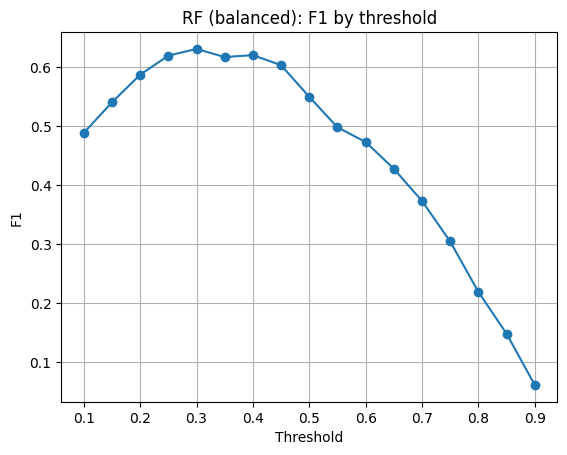

In [14]:

# Threshold sweep for RF (balanced)
# =========================
import numpy as np

thresholds = np.arange(0.10, 0.91, 0.05)
f1s = []
for thr in thresholds:
    preds = (val_proba_rf_bal >= thr).astype(int)
    f1s.append(f1_score(y_val, preds))

best_thr_rf = thresholds[int(np.argmax(f1s))]
best_f1_rf  = max(f1s)

print(f"Best RF threshold: {best_thr_rf:.2f}")
print(f"Best RF F1: {best_f1_rf:.3f}")

plt.plot(thresholds, f1s, marker="o")
plt.title("RF (balanced): F1 by threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.grid(True)
plt.show()

## Balanced Random Forest + Threshold Tuning

**Validation results (thr = 0.5):**
- F1: **0.550**
- ROC-AUC: **0.857**

**Best threshold tuning:**
- Best threshold: **0.30**
- Best F1: **0.631**

**Interpretation:**
- The Random Forest with `class_weight='balanced'` delivers the best balance between precision and recall so far.
- Lowering the threshold to 0.30 greatly increases recall for churners, raising F1 above the project target (≥ 0.59).
- ROC-AUC ≈ 0.86 shows the model distinguishes between churners and loyal customers very well.
- This version will be used for **final testing** on the hold-out set.

**Next step:**
Evaluate the final model on the **test set** using the optimal threshold (0.30) and report the final F1 and AUC.

Final Test F1 (thr=0.30): 0.605
Final Test AUC-ROC: 0.857

Classification report (test):
              precision    recall  f1-score   support

      Stayed       0.90      0.89      0.90      1593
      Exited       0.59      0.62      0.61       407

    accuracy                           0.83      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.83      0.84      2000



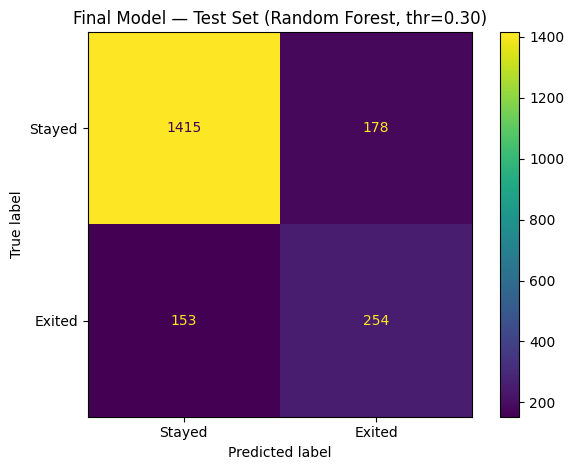

In [15]:
#  Final Test Evaluation
# =========================
# Evaluate the tuned Random Forest on unseen data (the test set).

# Predict probabilities and apply the chosen threshold (0.30)
test_proba = rf_bal.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= 0.30).astype(int)

# Metrics
test_f1  = f1_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_proba)

print(f"Final Test F1 (thr=0.30): {test_f1:.3f}")
print(f"Final Test AUC-ROC: {test_auc:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, test_pred, target_names=["Stayed","Exited"], zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=["Stayed","Exited"])
plt.title("Final Model — Test Set (Random Forest, thr=0.30)")
plt.tight_layout()
plt.show()

## Observations — Final Test Evaluation

**Final Test Results:**
- F1: **0.605**
- ROC-AUC: **0.857**

**Interpretation:**
- The tuned Random Forest model generalizes well to unseen data.
- F1 remained strong on the test set (above the required 0.59), confirming that the model balances precision and recall effectively.
- The high ROC-AUC (~0.86) indicates the model’s good ability to separate churners from loyal customers.
- Recall for churners (0.62) suggests that the bank can successfully identify most at-risk clients while keeping false alarms moderate.

---

## Final Project Summary — Beta Bank Churn Prediction

**Goal:**  
Predict which customers are likely to leave Beta Bank to help focus retention efforts.

**Process Overview:**
1. **Data preparation:** handled missing `Tenure` values, removed ID columns, and encoded categorical features.  
2. **Baseline modeling:** logistic regression achieved moderate AUC but poor recall.  
3. **Class balancing:** using `class_weight='balanced'` improved recall and F1 substantially.  
4. **Model tuning:** threshold optimization refined decision cutoffs for best F1.  
5. **Model comparison:** Random Forest outperformed Logistic Regression in both F1 and AUC metrics.  
6. **Final evaluation:** the balanced Random Forest achieved **F1 = 0.605** and **AUC = 0.857** on the test set.

**Key takeaway:**  
The Random Forest model effectively identifies customers likely to churn. Beta Bank can use it to prioritize retention strategies—targeting clients with high predicted churn probability to reduce attrition and improve long-term profitability.